In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('iris.csv')

In [2]:
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal.length    150 non-null float64
sepal.width     150 non-null float64
petal.length    150 non-null float64
petal.width     150 non-null float64
variety         150 non-null object
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
data['variety'].value_counts()

Versicolor    50
Setosa        50
Virginica     50
Name: variety, dtype: int64

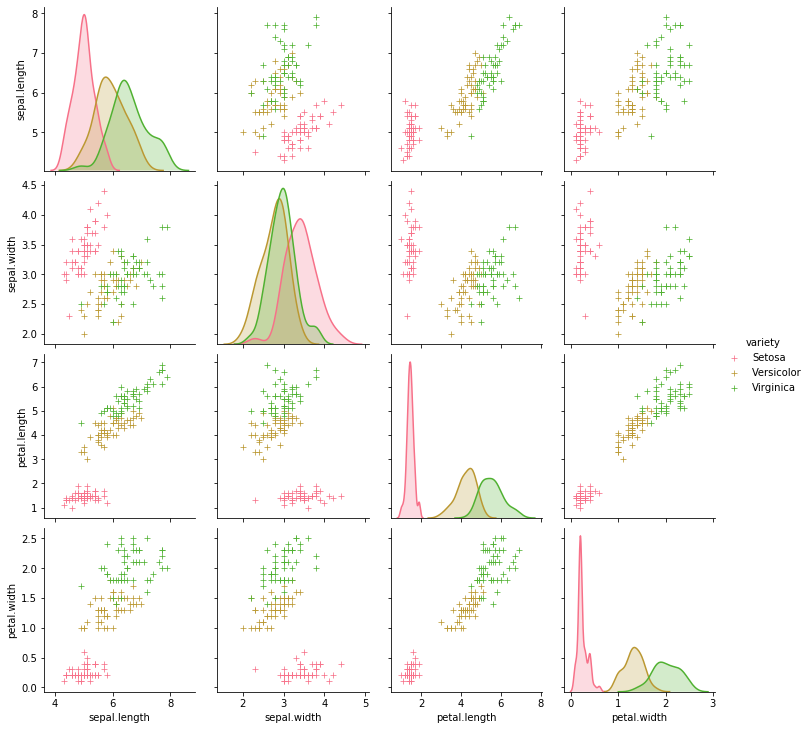

In [5]:
g = sns.pairplot(pd.DataFrame(data), hue='variety', markers='+')
plt.show()

In [6]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def normalize_data(arraynp):
    mean = np.mean(arraynp,0)
    standard = np.std(arraynp,0)
    for i in range(0,arraynp.shape[0]):
        arraynp[i] = np.true_divide((arraynp[i] - mean), standard)
    return arraynp



def accuracy(x, parameters, y):
    probs, caches = forward(x, parameters)
    labels = (probs >= 0.5) * 1 #redondeamos prediccion
    accuracy = np.mean(labels == y) * 100

    return round(accuracy,2)
       
def Split(data):
    n = data.shape[1]
    X = data[:, :n-1]
    y = data[:, n-1:]
    return X, y
    


def k_folds(data, k):
    
    y = data['variety']
    clase_0 = np.count_nonzero( y == 0)
    clase_1 = np.count_nonzero( y == 1)
    clase_2 = np.count_nonzero( y == 2)


    div0 = int(clase_0/3)
    div1 = int(clase_1/3)
    div2 = int(clase_2/3)

    class_1 = data[0:clase_1, :]
    class_0 = data[clase_1:clase_1+clase_0, :]

    np.random.shuffle(class_0)
    np.random.shuffle(class_1)
    
    size_fold = int(data.shape[0] / k)
    remainder_size_fold = int(data.shape[0] % k)
    data = data[:data.shape[0] - remainder_size_fold, :]

    k_fols = []
    idx_row0 = 0
    idx_row1 = 0
    for i in range(k):
        X0 = class_0[idx_row0:idx_row0+div0, :]
        X1 = class_1[idx_row1:idx_row1+div1, :]
        X = np.concatenate((X0, X1))
        k_fols.append(X)
        idx_row0 += div0
        idx_row1 += div1
    return k_fols



#Funcion que convierte datos categoricos en numericos
def one_hot_encode( data ):
    values = array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)    
    return onehot_encoded
y_train = data['variety']
x_train = data.drop('variety', axis=1)

#transformamos la salida
y_train = one_hot_encode(y_train)

# Inicializacion de parametros

In [7]:
#Inicialziacion del diccionario de parametros(pesos y bias)
def initialize_parameters(layers_dims):
    np.random.seed(1)               
    parameters = {} #diccionario
    L = len(layers_dims) #cantidad de capas  
    
    #ignoramos la capa de entrada (indice 0)
    for l in range(1, L):
        #Inicializamos la matriz de pesos aleatoriamente segun distribucion normal uniforme
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 0.01
        #Inicializamos la matriz de bias en ceros
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        #verificamos dimensiones
        assert parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)
        
    #retorna matriz de pesos y vector de bias para cada capa
    return parameters

# Forward Propagation

FUNCIONES DE ACTIVACION

In [8]:
#funcion sigmoidea
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z



FUNCIONES AUXILIARES E IMPLEMENTACION

In [9]:
#Funcion auxiliar para forward propagation: Calcula Z = W.A + b
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b  # Z = W.A + b _____(E1)
    #almacenamos en cache variables que usaremos en back propagation
    cache = (A_prev, W, b) #tupla que almacena A_prev, W  y b
    return Z, cache

#Funcion auxiliar para forward propagation: Aplicar funcion de activacion
def linear_activation_forward(A_prev, W, b, activation_fun):
    assert activation_fun == "sigmoid" 

    if activation_fun == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z) #_____(E2)

    assert A.shape == (W.shape[0], A_prev.shape[1]) #comprobamos las dimensiones de A(W*A_prev)

    #almacenamos en cache variables que usaremos en back propagation:
    #linear_cache: A_prev, W y b
    #activation_cache: Z antes de aplicar la funcion de activacion
    cache = (linear_cache, activation_cache)
    return A, cache


#Forward propagation: Calcula la capa de salida, al iterar sobre las otras capas
def forward(X, parameters):
    hidden_layers_activation_fun="sigmoid"
    A = X                           
    caches = [] #caches por cada capa                    
    L = len(parameters) // 2  #por cada capa hay W y b (X2)    

    #ignoramos la capa de entrada (indice 0)
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation_fun=hidden_layers_activation_fun)
        caches.append(cache) #agregamos la nueva informacion de cache

    #La ultima capa aplica la funcion sigmoidea siempre, sin importar que funcion hemos especificado
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation_fun="sigmoid")
    caches.append(cache)
    
    return AL, caches

# Funcion de costo

In [10]:
#Usamos como funcion de costo cross entrophy
#Recibe Al: array de probabilidades y y:vector de respuestas
def compute_cost(AL, y):
    m = y.shape[1]              
    cost = - (1 / m) * np.sum(np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL))) #_____(E3)
    return cost

# Back Propagation

DERIVADAS DE LAS FUNCIONES DE ACTIVACION

In [11]:
#Reciben dA:vector post activacion y Z:entrada para esa activacion
def dS(dA, Z):
    A, Z = sigmoid(Z) #Z regresa igual
    dZ = dA * A * (1 - A) #dA * derivada(Z) _____(E9)
    return dZ


FUNCIONES AUXILIARES E IMPLEMENTACION

In [12]:
#funcion auxiliar para back propagation: Calcula la gradiente con respecto al peso, bias y A_previo(post activacion)
#Recibe dZ:gradiente de costo con respecto a Z
        #cache: valores de (A_prev, W, b) provenientes del forward_popagation en la capa actual.
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T) #_____(E6)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True) #_____(E7)
    dA_prev = np.dot(W.T, dZ) #_____(E8)

    #comprobamos las dimensiones de los resultados
    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


#funcion auxiliar para back propagation:
def linear_activation_backward(dA, cache, activation_fun):
    #linear_cache: A_prev, W y b
    #activation_cache: Z antes de aplicar la funcion de activacion
    linear_cache, activation_cache = cache #las separamos

    if activation_fun == "sigmoid":
        dZ = dS(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


#Back propagation: Calcula el gradiente de la capa de salida desde la capa de salida en orden inverso
def backward(AL, y, caches):
    hidden_layers_activation_fun="sigmoid"
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL)) #AL -Y / AL(1-AL) _____(E4)
    
    #Comenzamos en la capa de salida (siempre con sigmoidea)... _____(E5)
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, caches[L - 1], "sigmoid")

    #... y continuamos en orden inverso
    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads["db" + str(l)] = linear_activation_backward(grads["dA" + str(l)], current_cache, hidden_layers_activation_fun)

    return grads

def Gradiente_Descendiente(X, Y, weights, iteraciones, learning, activations):
    costos = [0] * iteraciones
    for i in range(iteraciones):
        cost = 0
        for j,x in enumerate(X):
            y_p, activation = Forward(x, weights, activations)
            c = Calcular_Funcion_Costo(y_p,Y[j])
            cost += c
            weights = Backward(y_p, Y[j], activations, weights, learning,c)
        costos[i] = cost / (len(X))
    return weights, costos

# Actualizar parametros

In [13]:
#Actualiza las matrices de pesos y los vectores de bias
#Recibe parameters: pesos y bias de todas las capas y grads:todas las gradientes calculadas
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 #por cada capa hay W y b (X2) 
    #Por cada capa, actualizamos pesos y bias
    for l in range(1, L + 1):
        # theta = theta - a.gradiente
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

# RED NEURONAL

In [14]:
def MLP(X, y, layers_dims, learning_rate=0.01, num_iterations=1500):
    hidden_layers_activation_fun="sigmoid"
    np.random.seed(1)

    # Inicializamos los parametros
    parameters = initialize_parameters(layers_dims)

    # Inicializamos la lista de costos
    cost_list = []

    # Iteramos tantas veces como se especifica
    for i in range(num_iterations):
        #Aplicamos forward_propagation
        AL, caches = forward(X, parameters)

        #Calcular funcion de costo
        cost = compute_cost(AL, y)

        #Aplicar back_propagation
        grads =backward(AL, y, caches)

        #Actualizar los parametros
        parameters = update_parameters(parameters, grads, learning_rate)
        
        #print(f"El costo despues de {i + 1} iteraciones es: {cost:.4f}")
        cost_list.append(cost)
        
    #Graficamos la curva de costo
   # plt.figure(figsize=(10, 6))
   # plt.plot(cost_list)
    #plt.xlabel("Iteraciones")
    #plt.ylabel("Costo")
    #plt.title(f"Curva de costo para ratio de aprendizaje = {learning_rate}")


    return parameters

# Aplicacion

In [15]:


lear_rat = [0.1,0.2,0.3, 0.4, 0.5]
num_iter = [100,200, 500, 1000, 1500]
matrix=[[200,300, 500, 1000, 2000],[200,300, 500, 1000, 2000],[200,300, 500, 1000, 2000],[200,300, 500, 1000, 2000],[200,300, 500, 1000, 2000]]
# Transform input data and label vector
x_train = x_train.T
y_train = y_train.T
for i in range(len(lear_rat)):

    for j in range(len(num_iter)):    
        #Determinamos dimensiones de las capas
        n = x_train.shape[0]

        layers_dims = [n, 2*n, 3] # 1 capas oculta de 2*n neuronas, 3 neuronas de salida
        print(lear_rat[i])
        print(num_iter[j])
        theta = MLP( x_train, y_train, layers_dims, learning_rate=lear_rat[i], num_iterations=num_iter[j])
        matrix[i][j]=accuracy(x_train,theta,y_train)

mostrar = pd.DataFrame(data = matrix, index= lear_rat, columns = num_iter)    

mostrar

0.1
100
0.1
200
0.1
500
0.1
1000
0.1
1500
0.2
100
0.2
200
0.2
500
0.2
1000
0.2
1500
0.3
100
0.3
200
0.3
500
0.3
1000
0.3
1500
0.4
100
0.4
200
0.4
500
0.4
1000
0.4
1500
0.5
100
0.5
200
0.5
500
0.5
1000
0.5
1500


,100,200,500,1000,1500
0.1,66.67,68.00,87.78,98.22,98.67
0.2,68.00,87.78,98.22,98.67,98.67
0.3,88.22,88.00,95.78,98.00,98.67
0.4,87.78,94.00,95.56,97.78,99.11
0.5,87.78,96.67,96.00,97.78,98.22


In [32]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score


data = pd.read_csv('iris.csv')

X = data.drop('variety', axis=1)
y = data['variety']


kernels = ['linear', 'poly', 'sigmoid']
Cs = [0.5,1.0,1.5, 2.0,2.5, 3.0, 10.0] 





X_train , X_test, y_train, y_test = train_test_split(X,y)

print(X_train.shape)
print(y_train.shape)


matrix_=[[0.5,1.0,1.5, 2.0,2.5, 3.0, 10.0] ,[0.5,1.0,1.5, 2.0,2.5, 3.0, 10.0]  ,[0.5,1.0,1.5, 2.0,2.5, 3.0, 10.0] ]

for m in range(len(kernels)):
    for i in range(len(Cs)):
        print("entro")

        model = svm.SVC(C=Cs[i], kernel=kernels[m])
        model.fit(X_train, y_train)
        acc_test = model.score(X_test, y_test)     
        matrix_[m][i]=acc_test

        
mostrar1 = pd.DataFrame(data = matrix_, index= kernels, columns = Cs)    

mostrar1


(112, 4)
(112,)
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro
entro


,0.5,1.0,1.5,2.0,2.5,3.0,10.0
linear,0.947368,0.947368,0.947368,0.947368,0.947368,0.973684,0.973684
poly,0.973684,0.973684,0.973684,0.973684,0.973684,0.973684,0.973684
sigmoid,0.263158,0.263158,0.263158,0.263158,0.263158,0.263158,0.184211
